# Collecting reservoir performance data on selection of targets

This notebook uses the general pipeline defined in 2022_03_06 notebook to generate NMSE performance on various reservoir tasks.


In [2]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

## SETUP

### Importing the dataset

For now, we use the HydroShoot dataset generated during the first semester.

In [3]:
from src.model.rc_dataset import ExperimentDataset

csv_path = '../datasets/hydroshoot_large_trimmed.csv'
dataset = ExperimentDataset(csv_path=csv_path)
print(dataset)

Dataset properties:
	n_runs:      84
	n_steps:    168
	state_size: 360

Available targets: 
	input_Tac, input_u, input_hs, input_Rg, output_Rg, output_An, output_E, output_Tleaf

Available state variables: 
	state_An, state_E, state_Eabs, state_Ei, state_Flux, state_FluxC, state_Tlc, state_gb, state_gs, state_psi_head, state_u



### Data preprocessing

Preprocessing pipeline is predefined in the `preprocessing` module of this directory. 

See printed docstring for all steps applied:

In [4]:
from preprocessing import preprocess_data

print(preprocess_data.__doc__)


    Preprocessing performed: 

    1. The target signal for each run is computed.
        - Target and reservoir are cast into a ndarray.
    2. Target and reservoir signals are trimmed.
        - A warmup mask is applied to target and reservoir.
        - A night-time mask is applied to target and reservoir.
    3. Target and reservoir are rescaled to zero-mean and unit variance
        - Normalizing transform is fitted on the entire dataset of included experiment runs.
    


For all experiments, we will use the following preprocessing parameters:

In [5]:
from src.learning.preprocessing import generate_mask

STATE_SIZE = 16                         # Sixteen random nodes are selected as reservoir readouts
RUN_IDS = np.arange(dataset.n_runs())   # All runs are used
WARMUP_STEPS = 4 * 24                   # First 4 days of each simulation are discarded
DAY_MASK = generate_mask(5, 21)         # All nighttime data between 5am and 9pm (inclusive) is discarded

### Grouping 

Grouping strategy is predefined in the `learning` module of this directory.

See printed docstring for a description of the grouping strategy:

In [6]:
from learning import group_by_day

print(group_by_day.__doc__)

Simulation state from the same calendar day of simulation inputs, 
    across all runs, are grouped together per day. Shape of X is assumed to be (runs, time_steps, nodes)

    ```
    GROUP 1 | GROUP 2 | GROUP 3 | GROUP 4 | ...
    --------+---------+---------+---------+----
    sim1/d1  sim1/d2   sim1/d3   /         /
    /        sim2/d2   sim2/d3   sim2/d4   /       ...
    /        /         sim3/d3   sim3/d4   sim3/d5 
                                ...                ...
    ```
    


### Train-test-splitting

Train-test splits are generated in contiguous blocks to avoid strong temporal correlation between the training and testing data.

In [7]:
from learning import train_test_split_blocks

print(train_test_split_blocks.__doc__)


    - Train-test splitting is done at group scope (i.e. by calendar day)
    - Training and testing ranges are chosen as contiguous blocks rather 
      than randomly selected.

    e.g. for `interval_length = 8` and `test_ratio = 0.25`, 
    the consecutive groups are assigned as follows:

    ```
    g1     g2      g3      g4      g5      g6      g7     g8                   
    ------+-------+-------+-------+-------+-------+------+------+
    Train | Train | Train | Train | Train | Train | Test | Test | ... (repeat)
    ```
    


In [8]:
TEST_RATIO = 0.25        # 25% of samples will be used for testing
INTERVAL_LENGTH = 16     # Every length of 16 consecutive calendar days is split in
                         # 12 training days and 4 testing days.

### Model definition

- Readout model is a standard RidgeRegression model with intercept term and CV-tuned regularization strength $\alpha$.
- CV search grid is a progression of logarithmicly spaced values for regularization strength $\alpha$.
- CV and testing metric is NMSE.

In [9]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

from src.learning.scorers import nmse_scorer

N_FOLDS = 5;


# Define model
readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

# define search grid
search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-3), np.log10(1e3), 50)
}]

# define cross-validation and testing metric
scorer = nmse_scorer

# Define CV fold strategy
folds = GroupKFold(n_splits=N_FOLDS)

## DEFINING TARGETS

### Environmental targets

These tasks show that the reservoir has some capacity for awareness about recent inputs.

In [10]:
from data_generators import direct_target_generator, direct_reservoir_generator

In [19]:
input_target_names = dataset.get_input_variables()
input_targets_runs = [list(direct_target_generator(dataset, name, RUN_IDS)) for name in input_target_names]

input_targets = list(zip(input_target_names, input_targets_runs))

print('Input targets:')
for name, _ in input_targets:
  print(f'\t- {name}')

Input targets:
	- input_Tac
	- input_u
	- input_hs
	- input_Rg


### Physiological activity on organism level

Theses tasks show that the reservoir has some capacity for awareness about its own fitness functions/unit performance.

In [20]:
output_target_names = dataset.get_output_variables()
output_target_runs = [list(direct_target_generator(dataset, name, RUN_IDS)) for name in output_target_names]

output_targets = list(zip(output_target_names, output_target_runs))

print('Output targets:')
for name, _ in output_targets:
  print(f'\t- {name}')

Output targets:
	- output_Rg
	- output_An
	- output_E
	- output_Tleaf


### Computational benchmarks

These tasks test the capability of the reservoir to 

1. compute nonlinear transformations of input signals
2. remember past inputs
3. Or a combination of the above.

#### Delay line

The reservoir must predict a delayed version of the target signal.

In [55]:
from data_generators import direct_target_generator, direct_reservoir_generator

def delayed_target_generator(delay_steps, dataset, target, run_ids):
  base_targets = direct_target_generator(dataset, target, run_ids)
  for base in base_targets:
    yield base[:-delay_steps]

def delayed_reservoir_generator(delay_steps, dataset, target, run_ids, **kwargs):
  base_targets = direct_reservoir_generator(dataset, target, run_ids, **kwargs)
  for base in base_targets:
    yield base[delay_steps:]


dtg = delayed_target_generator(2, dataset, 'input_Tac', [0, 1, 2])
drg = delayed_reservoir_generator(2, dataset, 'state_Tlc', [0, 1, 2], state_size=8)
print(f'Target shape: {next(dtg).shape}')
print(f'State shape:  {next(drg).shape}')

Target shape: (166,)
State shape:  (166, 8)


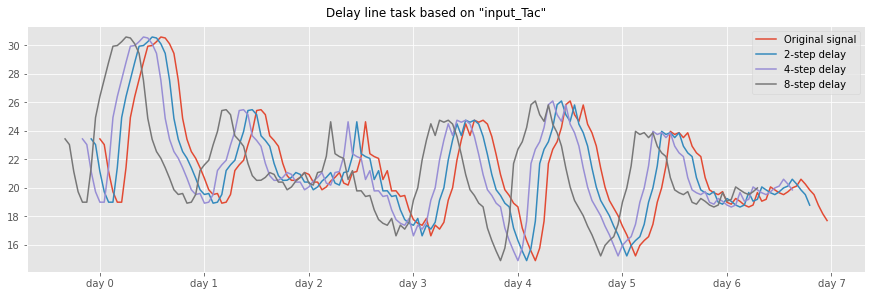

In [75]:
tg = direct_target_generator(dataset, 'input_Tac', [0, 1, 2])
dtg2 = delayed_target_generator(2, dataset, 'input_Tac', [0, 1, 2])
dtg4 = delayed_target_generator(4, dataset, 'input_Tac', [0, 1, 2])
dtg8 = delayed_target_generator(8, dataset, 'input_Tac', [0, 1, 2])

base = next(tg)
delayed2 = next(dtg2)
delayed4 = next(dtg4)
delayed8 = next(dtg8)

x_base = np.arange(0, len(base))
x_delayed2 = np.arange(-2, len(delayed2) - 2)
x_delayed4 = np.arange(-4, len(delayed4) - 4)
x_delayed8 = np.arange(-8, len(delayed8) - 8)

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 1, figsize=(12, 4), constrained_layout=True)

  ax.plot(x_base, base , label='Original signal')
  ax.plot(x_delayed2, delayed2, label='2-step delay')
  ax.plot(x_delayed4, delayed4, label='4-step delay')
  ax.plot(x_delayed8, delayed8, label='8-step delay')

  x_ticks = np.arange(0, len(base) + 1, 24)
  ax.set_xticks(x_ticks)
  ax.set_xticklabels([f'day {i}' for i in range(len(x_ticks))])

  ax.legend()

  fig.suptitle('Delay line task based on "input_Tac"')
  plt.show()

#### Polynomial transformation

The reservoir must predict a polynomial transformation of an input signal.

In [78]:
def polytransform_target_generator(exponent, dataset, target, run_ids):
  base_targets = direct_target_generator(dataset, target, run_ids)
  for base in base_targets:
    yield base ** exponent

pttg = polytransform_target_generator(2, dataset, 'input_Tac', [0, 1, 2])
print(f'Target shape: {next(pttg).shape}')

Target shape: (168,)


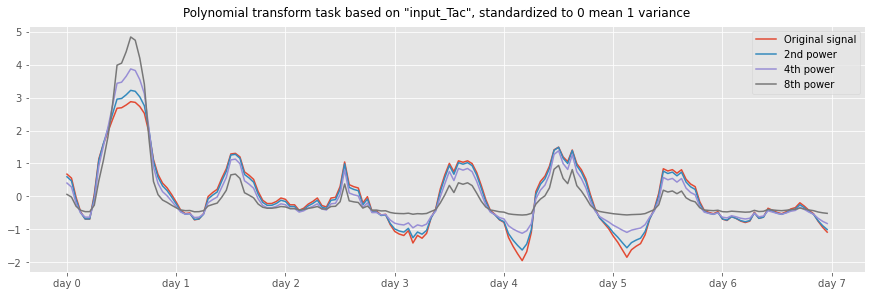

In [86]:
tg = direct_target_generator(dataset, 'input_Tac', [0, 1, 2])
pttg2 = polytransform_target_generator(2, dataset, 'input_Tac', [0, 1, 2])
pttg4 = polytransform_target_generator(4, dataset, 'input_Tac', [0, 1, 2])
pttg8 = polytransform_target_generator(8, dataset, 'input_Tac', [0, 1, 2])

base = next(tg)
exponent2 = next(pttg2)
exponent4 = next(pttg4)
exponent8 = next(pttg8)
base = (base - base.mean()) / base.std()
exponent2 = (exponent2 - exponent2.mean()) / exponent2.std()
exponent4 = (exponent4 - exponent4.mean()) / exponent4.std()
exponent8 = (exponent8 - exponent8.mean()) / exponent8.std()

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 1, figsize=(12, 4), constrained_layout=True)

  ax.plot( base, label='Original signal')
  ax.plot(exponent2, label='2nd power')
  ax.plot(exponent4, label='4th power')
  ax.plot(exponent8, label='8th power')

  x_ticks = np.arange(0, len(base) + 1, 24)
  ax.set_xticks(x_ticks)
  ax.set_xticklabels([f'day {i}' for i in range(len(x_ticks))])

  # ax.set_yscale('log')

  ax.legend()

  fig.suptitle('Polynomial transform task based on "input_Tac", standardized to 0 mean 1 variance')
  plt.show()

#### NARMA Benchmark

Computational benchmark for reservoir computers.

## FITTING READOUT FUNCTIONS

In [33]:
all_targets = [
  *input_targets,
  *output_targets
]

print(f'Collecting readout performance data on {len(all_targets)} target signals:')
for (name, _) in all_targets:
  print(f'\t- {name}')

	- input_Tac
	- input_u
	- input_hs
	- input_Rg
	- output_Rg
	- output_An
	- output_E
	- output_Tleaf


In [22]:
from tqdm import tqdm

from src.learning.training import perform_gridsearch

from data_generators import direct_reservoir_generator
from learning import group_by_day


state_variables = dataset.get_state_variables()

total_loops = len(state_variables) * len(all_targets)
print(f'Performing {total_loops} fits...')

models = {}
results = []

with tqdm(total=total_loops) as pbar:

    for state_var in state_variables:

        # the reservoir is the same for every target
        reservoir_run_list = list(direct_reservoir_generator(dataset, state_var, RUN_IDS, STATE_SIZE, random_state=42))

        for (target_name, target_generator) in all_targets:
            # Preprocess data for model fit
            X, y = preprocess_data(dataset, RUN_IDS, target_generator, reservoir_run_list, STATE_SIZE,
                                warmup_steps=WARMUP_STEPS, day_mask=DAY_MASK)
            
            # Generate group labels and make train/test split
            days_per_run = X.shape[1] // DAY_MASK.sum()
            groups = group_by_day(X, days_per_run)
            train, test = train_test_split_blocks(X, y, groups, TEST_RATIO, INTERVAL_LENGTH)
            X_train, y_train, groups_train = train

            # fit model
            model, scores = perform_gridsearch(readout, X_train, y_train, groups_train, folds, search_grid, verbose=False)
            (train_mean, train_std), (cv_mean, cv_std) = scores

            # determine test score
            X_test, y_test, _ = test
            test_score = scorer(model, X_test, y_test)
            models[(target_name, state_var)] = model
            results.append({
                'target': target_name,
                'state_var': state_var,
                'test_score': test_score,
                'train_mean': train_mean,
                'train_std': train_std,
                'cv_mean': cv_mean,
                'cv_std': cv_std
            })
            pbar.update(1)


Performing 88 fits...


100%|██████████| 88/88 [00:16<00:00,  5.19it/s]


### Store results

In [32]:
# import arrow

# time_string = arrow.get().format('YYYY-MM-DD_HH.mm.ss')

results_df = pd.DataFrame.from_dict(results)
results_df = results_df.set_index(['target', 'state_var'])
results_df.head()
results_df.to_csv(f'test_results.csv')

results_df.loc['input_Tac'][['test_score', 'cv_mean']]

,test_score,cv_mean
state_var,,
state_An,-0.535314,-0.511366
state_E,-0.409964,-0.404094
state_Eabs,-0.657299,-0.563379
state_Ei,-0.657299,-0.563379
state_Flux,-0.408823,-0.405483
state_FluxC,-0.535165,-0.510660
state_Tlc,-0.233090,-0.229533
state_gb,-0.972978,-0.894151
state_gs,-0.514811,-0.509837


#### Some analysis of test results

In [36]:
results_sorted = results_df.sort_values('test_score', ascending=False)
results_sorted.head(10)

test_score  train_mean  train_std   cv_mean  \
target       state_var                                                     
input_Tac    state_Tlc        -0.233090   -0.220761   0.003945 -0.229533   
output_Tleaf state_Tlc        -0.249496   -0.240216   0.004097 -0.247436   
input_u      state_u          -0.295020   -0.291508   0.006023 -0.294529   
input_Rg     state_Eabs       -0.311191   -0.298981   0.001914 -0.302033   
             state_Ei         -0.311191   -0.298981   0.001914 -0.302033   
input_u      state_gb         -0.317892   -0.315156   0.004140 -0.318500   
input_Rg     state_Tlc        -0.337594   -0.309007   0.002757 -0.317083   
output_E     state_psi_head   -0.348631   -0.316259   0.004675 -0.320432   
input_Rg     state_psi_head   -0.357667   -0.312422   0.003370 -0.320098   
output_Tleaf state_psi_head   -0.375311   -0.337086   0.001181 -0.353503   

                               cv_std  
target       state_var                 
input_Tac    state_Tlc       0.018073  
output_Tleaf state_Tlc       0.018610  
input_u      state_u         0.022312  
input_Rg     state_Eabs      0.007340  
             state_Ei        0.007340  
input_u      state_gb        0.015063  
input_Rg     state_Tlc       0.011057  
output_E     state_psi_head  0.018450  
input_Rg     state_psi_head  0.014035  
output_Tleaf state_psi_head  0.011393

In [46]:
results_sorted_top = results_sorted[results_sorted['test_score'] > -0.5]

results_sorted_top.groupby('target').count()

,test_score,train_mean,train_std,cv_mean,cv_std
target,,,,,
input_Rg,9,9,9,9,9
input_Tac,4,4,4,4,4
input_u,2,2,2,2,2
output_E,9,9,9,9,9
output_Rg,6,6,6,6,6
output_Tleaf,7,7,7,7,7


In [47]:
results_sorted_top.groupby('state_var').count()


,test_score,train_mean,train_std,cv_mean,cv_std
state_var,,,,,
state_An,3,3,3,3,3
state_E,5,5,5,5,5
state_Eabs,3,3,3,3,3
state_Ei,3,3,3,3,3
state_Flux,5,5,5,5,5
state_FluxC,3,3,3,3,3
state_Tlc,5,5,5,5,5
state_gb,1,1,1,1,1
state_gs,3,3,3,3,3
